In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import datetime
import gdown
from tensorflow.keras import models, layers, metrics
from transformers import BertTokenizerFast, DistilBertConfig, TFDistilBertModel
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import imblearn
from tqdm import tqdm

%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2023-05-29 21:03:03.371625: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/jupyter/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-29 21:03:04.922550: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-29 21:03:04.922568: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-29 21:03:04.923025: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-29 21:03:04.936215: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-05-29 21:03:04.936636: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully o

In [ ]:
# Defining settings for local GPU
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


2023-05-29 21:03:04.961636: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-29 21:03:04.961772: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-29 21:03:04.961898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2023-05-29 21:03:04.961913: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-29 21:03:04.962970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-29 21:03:04.962998: I tensorflow/stream_executor/platform/

In [ ]:
# Downloading the data
url = 'https://drive.google.com/file/d/1n_g9d0nFTOP-gioCJMmPwVD1gVeJhD0n/view?usp=sharing'
gdown.download(url, 'df_reviews.csv', quiet = False, fuzzy = True)

In [ ]:
# reading the data and transforming it into the classes
data = pd.read_csv('df_reviews.csv', usecols=['review_comments', 'review_rating'])

data['review_comments'] = data['review_comments'].astype(str)
data['review_rating'] = data['review_rating'].astype(str)

data['review_rating'] = data['review_rating'].apply(lambda x: 1 if x == 'positive' else 0)
num_classes = len(data['review_rating'].unique())

X = data['review_comments']
y = np.unique(data['review_rating'], return_inverse=True)[1]

In [ ]:
# Creating the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [ ]:
# Tokenizing the data to the format required by the DistilBERT model. Training and test sets are tokenized separately
tokenizer = BertTokenizerFast.from_pretrained('distilbert-base-uncased')
X_train = [tokenizer(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in tqdm(X_train)]
X_train = np.array(X_train, dtype='int32')

X_test = [tokenizer(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in tqdm(X_test)]
X_test = np.array(X_test, dtype='int32')

In [ ]:
# Extracting the features from the inputs using the DistilBERT model

config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_tf = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

input_ids_in = layers.Input(shape=(512,), dtype='int32')
x = dbert_tf(input_ids=input_ids_in)[0][:,0,:]

feature_extractor = models.Model(inputs=input_ids_in, outputs=x)
feature_extractor.compile()

# extract features
X_train_features = feature_extractor.predict(X_train, verbose=1, batch_size=16, use_multiprocessing=True)
X_test_features = feature_extractor.predict(X_test, verbose=1, batch_size=16, use_multiprocessing=True)
print(X_train.shape)

In [ ]:
# save the datasets to npy
np.save('X_train.npy', X_train_features)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test_features)
np.save('y_test.npy', y_test)

In [ ]:
# load the datasets from npy
X_train_features = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test_features = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [ ]:
# Get an overview of the class distribution
neg, pos = np.bincount(y_train)
total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 528516
    Positive: 523206 (99.00% of total)



In [ ]:
# Oversampling using Random Oversampling to balance the classes by creating more instances of the smaller class (0 / negative comments)
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_features, y_train = oversample.fit_resample(X_train_features, y_train)

In [ ]:
# Recheck the class distribution
neg, pos = np.bincount(y_train)
total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1046412
    Positive: 523206 (50.00% of total)



In [ ]:
# Create the Training and Validation split for training
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_train_features, y_train, test_size=0.25, random_state=42)

In [ ]:
# Defining the model architecture
input = layers.Input(shape=(768,), dtype='float32')
x = layers.Dense(256, activation='tanh', kernel_initializer= 'he_normal')(input)
x = layers.Dense(128, activation='tanh', kernel_initializer= 'he_normal')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='tanh', kernel_initializer= 'he_normal')(x)
x = layers.Dense(32, activation='tanh', kernel_initializer= 'he_normal')(x)
x = layers.Dropout(0.1)(x)
out = layers.Dense(2, activation='softmax', dtype = 'float32')(x)

model = models.Model(inputs=input, outputs = out)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=[metrics.SparseCategoricalAccuracy()])

  opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt)



In [ ]:
# Define the callback for model Training
callbacks = [ModelCheckpoint('final_model_tanh.hdf5', verbose=1, save_best_only=True, save_weights_only=True,
                             monitor = 'val_loss'),
            EarlyStopping(monitor='val_loss', patience=64, verbose=1, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=16, verbose=1, min_lr=1e-8),
            tensorboard_callback]

In [ ]:
# Train the model
history = model.fit(X_tf_train, y_tf_train, batch_size=512, shuffle=True, epochs=512, validation_data=(X_tf_test, y_tf_test), 
                       callbacks = callbacks)

2023-05-29 21:03:14.218825: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2410933248 exceeds 10% of free system memory.
2023-05-29 21:03:14.569270: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-29 21:03:14.569529: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4199835000 Hz


Epoch 1/512
  20/1533 [..............................] - ETA: 4s - loss: 0.6920 - sparse_categorical_accuracy: 0.6017   

2023-05-29 21:03:14.924140: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-29 21:03:15.062505: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-29 21:03:15.062521: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-29 21:03:15.062571: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-29 21:03:15.065081: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-05-29 21:03:15.065937: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-05-29 21:03:15.066484: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-

1533/1533 [==============================] - 4s 2ms/step - loss: 0.3193 - sparse_categorical_accuracy: 0.8564 - val_loss: 0.1817 - val_sparse_categorical_accuracy: 0.9348

Epoch 00001: val_loss improved from inf to 0.18171, saving model to final_model_tanh.hdf5
Epoch 2/512
1533/1533 [==============================] - 3s 2ms/step - loss: 0.2007 - sparse_categorical_accuracy: 0.9248 - val_loss: 0.1907 - val_sparse_categorical_accuracy: 0.9328

Epoch 00002: val_loss did not improve from 0.18171
Epoch 3/512
1533/1533 [==============================] - 3s 2ms/step - loss: 0.1850 - sparse_categorical_accuracy: 0.9316 - val_loss: 0.1619 - val_sparse_categorical_accuracy: 0.9431

Epoch 00003: val_loss improved from 0.18171 to 0.16186, saving model to final_model_tanh.hdf5
Epoch 4/512
1533/1533 [==============================] - 3s 2ms/step - loss: 0.1731 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.1564 - val_sparse_categorical_accuracy: 0.9443

Epoch 00004: val_loss improved from 0.161

Text(0.5, 1.02, 'Training Metrics for Random Oversamplling')

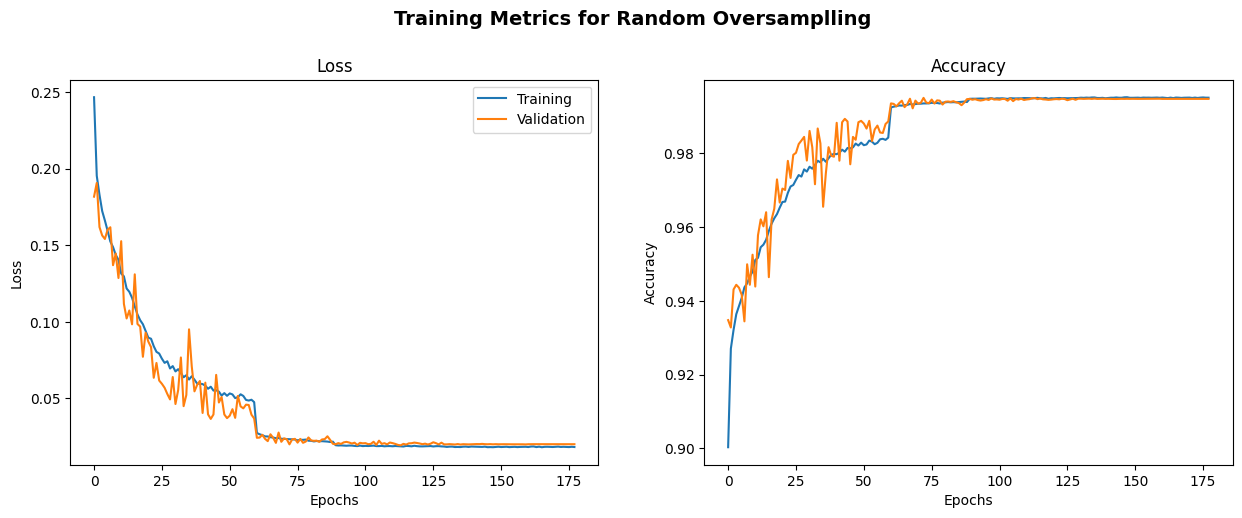

In [ ]:
# Plot the training history

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['sparse_categorical_accuracy'], label='Training')
ax[1].plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

fig.suptitle('Training Metrics for Random Oversamplling', fontsize=14, fontweight='bold', y=1.02)

In [ ]:
# Predict the test set
y_pred = model.predict(X_test_features, verbose = 1, use_multiprocessing = True)

4130/4130 [==============================] - 2s 364us/step


In [ ]:
# Create a classification report for the test set predictions
y_pred_max = np.argmax(y_pred, axis=1)
report = classification_report(y_pred_max, y_test, output_dict=True)
report = pd.DataFrame(report).T
print(report)
report.to_csv('final_model_tanh.csv', index = False)

              precision    recall  f1-score       support
0              0.763554  0.445714  0.562864    2275.00000
1              0.990359  0.997582  0.993958  129854.00000
accuracy       0.988080  0.988080  0.988080       0.98808
macro avg      0.876957  0.721648  0.778411  132129.00000
weighted avg   0.986454  0.988080  0.986535  132129.00000


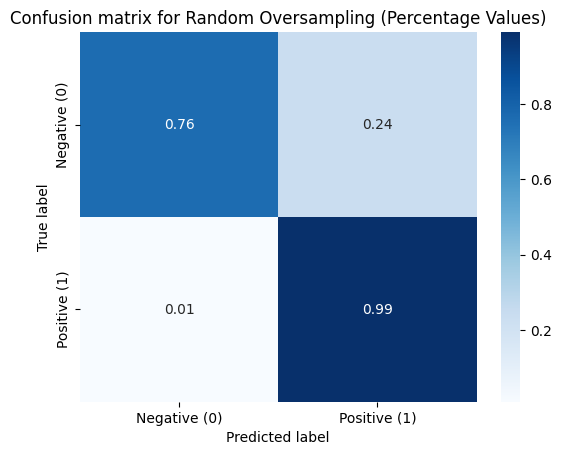

In [ ]:
# cereate a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_max)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues")
# change the lables to Predicted and True
plt.ylabel('True label')
plt.xlabel('Predicted label')
labels = ['Negative (0)', 'Positive (1)']
plt.xticks(np.arange(2) + 0.5, labels)
plt.yticks(np.arange(2) + 0.5, labels)
plt.title('Confusion matrix for Random Oversampling (Percentage Values)')
plt.show()

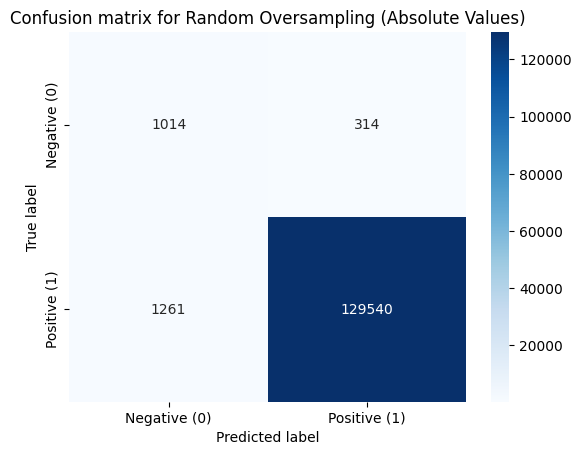

In [ ]:
cm = confusion_matrix(y_test, y_pred_max)
sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues")
# change the lables to Predicted and True
plt.ylabel('True label')
plt.xlabel('Predicted label')
labels = ['Negative (0)', 'Positive (1)']
plt.xticks(np.arange(2) + 0.5, labels)
plt.yticks(np.arange(2) + 0.5, labels)
plt.title('Confusion matrix for Random Oversampling (Absolute Values)')
plt.show()

In [ ]:
# Perform classification on selected examples

test_data = pd.read_csv('selected_examples.csv')

test_comments = test_data['reviews'].tolist()

tokenizer = BertTokenizerFast.from_pretrained('distilbert-base-uncased')
test_tokens = [tokenizer(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in tqdm(test_comments)]

# create a feature extractor
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_tf = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

input_ids_in = layers.Input(shape=(512,), dtype='int32')
x = dbert_tf(input_ids=input_ids_in)[0][:,0,:]

feature_extractor = models.Model(inputs=input_ids_in, outputs=x)
feature_extractor.compile()

test_features = feature_extractor.predict(np.array(test_tokens))

test_predictions = model.predict(test_features, verbose = 1, use_multiprocessing = True)

# print the prediction with the probability
max_predictions = np.argmax(test_predictions, axis=1)

test_report = classification_report(max_predictions, test_data['sentiment'], output_dict=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
100%|██████████| 1000/1000 [00:00<00:00, 5276.07it/s]
2023-05-29 21:11:04.937976: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initiali

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [ ]:
test_report = pd.DataFrame(test_report).T
print(test_report)

              precision    recall  f1-score   support
0              0.800000  0.615385  0.695652    39.000
1              0.984536  0.993757  0.989125   961.000
accuracy       0.979000  0.979000  0.979000     0.979
macro avg      0.892268  0.804571  0.842388  1000.000
weighted avg   0.977339  0.979000  0.977679  1000.000


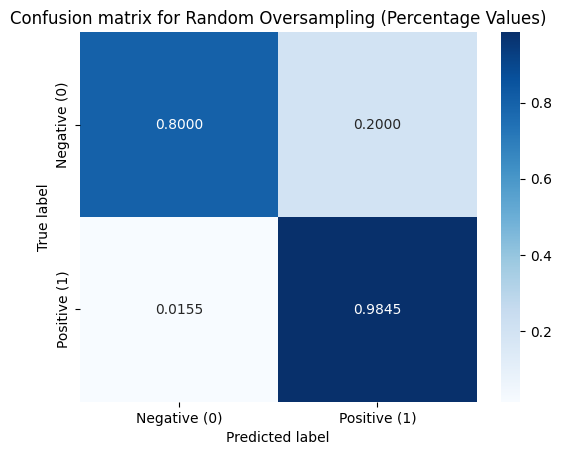

In [ ]:
# create teh confusion matrix like before
cm = confusion_matrix(test_data['sentiment'], max_predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, fmt='.4f', cmap="Blues")
# change the lables to Predicted and True
plt.ylabel('True label')
plt.xlabel('Predicted label')
labels = ['Negative (0)', 'Positive (1)']
plt.xticks(np.arange(2) + 0.5, labels)
plt.yticks(np.arange(2) + 0.5, labels)
plt.title('Confusion matrix for Random Oversampling (Percentage Values)')
plt.show()

In [ ]:
# get a list of the misclassified examples
misclassified = test_data[max_predictions != test_data['sentiment']]
# add teh predicted probability 
misclassified['probability'] = np.max(test_predictions, axis=1)[max_predictions != test_data['sentiment']]
# save the misclassified examples
misclassified.to_csv('misclassified_mixed.csv', index = False)

/tmp/ipykernel_4555/2515955946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['probability'] = np.max(test_predictions, axis=1)[max_predictions != test_data['sentiment']]
